In [2]:
# import torch
# import torchvision
# print("PyTorch version:", torch.__version__)
# print("Torchvision version:", torchvision.__version__)
# print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib onnx onnxruntime
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install onnxruntime-gpu nibabel

  Using cached onnxruntime-1.16.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.4 MB)
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-gbqzfv9m
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-gbqzfv9m
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything.utils.transforms import ResizeLongestSide
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel
from torch.nn import functional as F

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

In [8]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [4]:
!wget https://huggingface.co/visheratin/segment-anything-vit-b/resolve/main/encoder-quant.onnx
!wget https://huggingface.co/visheratin/segment-anything-vit-b/resolve/main/decoder-quant.onnx

--2023-11-24 23:12:50--  https://huggingface.co/visheratin/segment-anything-vit-b/resolve/main/encoder-quant.onnx
Resolving huggingface.co (huggingface.co)... 18.155.216.20, 18.155.216.42, 18.155.216.104, ...
Connecting to huggingface.co (huggingface.co)|18.155.216.20|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/4a/36/4a3602df8416e31bc3e12a089f9ae5d48bc7eda0623dcf4b3e912f1583a157d7/cf99a3b79eea0ac4f7c9b06cdce5b2763ff41a3f631213c748d497cba233df6a?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27encoder-quant.onnx%3B+filename%3D%22encoder-quant.onnx%22%3B&Expires=1701090771&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwMTA5MDc3MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy80YS8zNi80YTM2MDJkZjg0MTZlMzFiYzNlMTJhMDg5ZjlhZTVkNDhiYzdlZGEwNjIzZGNmNGIzZTkxMmYxNTgzYTE1N2Q3L2NmOTlhM2I3OWVlYTBhYzRmN2M5YjA2Y2RjZTViMjc2M2ZmNDFhM2Y2MzEyMTNjNzQ4ZD

In [58]:
checkpoint = "/scratch/itee/uqtdao4/seg_volume/MedSAM/work_dir/lesion_finetune_pointbox/sam_model_latest.pth"
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=checkpoint)

torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float)

import warnings

onnx_model_path = "./work_dir/lesion_finetune_pointbox/sam_finetuned_M2002_decoder_masksigmoid.onnx"

onnx_model = SamOnnxModel(sam, return_single_mask=False)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )

onnx_model_quantized_path = "./work_dir/lesion_finetune_pointbox/sam_finetuned_M2002_decoder_quant_masksigmoid.onnx"
quantize_dynamic(
    model_input=onnx_model_path,
    model_output=onnx_model_quantized_path,
    # optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)
onnx_model_path = onnx_model_quantized_path

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul]

In [3]:
encoder_path = "./work_dir/MRI_brain_lesion/encoder-quant.onnx"
decoder_path = "./work_dir/lesion_finetune_bgpoint/sam_finetuned_M2002_decoder_quant_masksigmoid.onnx"

encoder_session = onnxruntime.InferenceSession(encoder_path, providers=['CPUExecutionProvider'])
decoder_session = onnxruntime.InferenceSession(decoder_path, providers=['CPUExecutionProvider'])

2023-11-29 08:38:05.411217971 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 50359, index: 0, mask: {1, 33, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-11-29 08:38:05.411205237 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 50360, index: 1, mask: {2, 34, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-11-29 08:38:05.411232418 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 50362, index: 3, mask: {4, 36, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-11-29 08:38:05.411209525 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 50361, index: 2, mask: {3, 35, }, error code: 22 error msg: Invalid argument. Speci

In [17]:
import nibabel as nb
import torchvision.transforms as T

brain = nb.load('../images/sub-M2002_ses-a1440_T2w.nii').get_fdata()
print("len(brain)", len(brain[0][0]))
# view_slices_3d(brain_nomask, slice_nbr=100, vmin=0, vmax=1000, title='Head')
image_embedding = np.zeros(shape=(1, 256, 64, 64))
for i in range(len(brain[0][0])):
  nifti_slice = brain[:,:,i]
  # rotated = np.rot90(nifti_slice)
  # flipped = np.flip(rotated, 0)
  # img_norm = (flipped - np.min(flipped)) / np.clip(flipped.max() - flipped.min(), a_min=1e-8, a_max=None) * 255
  # flipped_slice = img_norm.astype(np.uint8)
  # stacked_img = np.stack((flipped_slice,)*3, axis=-1)

  image_size_encoder = 256
  ori_w, ori_h = nifti_slice.shape[-2:]
  padh = image_size_encoder - ori_h
  padw = image_size_encoder - ori_w

  lower_bound, upper_bound = np.percentile(nifti_slice, 0.5), np.percentile(nifti_slice, 99.5)
  image_data_pre = np.clip(nifti_slice, lower_bound, upper_bound)
  image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
  image_data_pre = np.uint8(image_data_pre)

  rotated = np.rot90(image_data_pre)
  flipped = np.flip(rotated, 0)
  flipped_slice = flipped.astype(np.uint8)
  img_slice_i_tensor = torch.as_tensor(flipped_slice, device="cpu")
  img_slice_i_tensor = F.pad(img_slice_i_tensor, (0, padw, 0, padh))
  img_slice_i = img_slice_i_tensor.numpy()
  stacked_img = np.stack((img_slice_i,)*3, axis=-1)

  image_size = 1024
  transform = ResizeLongestSide(image_size)

  input_image = transform.apply_image(stacked_img)
  input_image_torch = torch.as_tensor(input_image, device="cpu")
  input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
  pixel_mean = torch.Tensor([123.675, 116.28, 103.53]).view(-1, 1, 1)
  pixel_std = torch.Tensor([58.395, 57.12, 57.375]).view(-1, 1, 1)
  x = (input_image_torch - pixel_mean) / pixel_std

  h, w = x.shape[-2:]
  padh = image_size - h
  padw = image_size - w
  x = F.pad(x, (0, padw, 0, padh))
  x = x.numpy()
  encoder_inputs = {
      "x": x,
  }

  output = encoder_session.run(None, encoder_inputs)

  print(output[0].shape)
  if i == 0:
    image_embedding = output[0]
  else:
    image_embedding = np.concatenate([image_embedding, output[0]], 0)

  # print(image_embedding.shape)
np.save("../sub-M2002/ses-a1440/anat/sub-M2002_ses-a1440_T2w_extra.npy", image_embedding)

len(brain) 187


/tmp/ipykernel_32056/29508842.py:23: RuntimeWarning: invalid value encountered in divide
  image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
/tmp/ipykernel_32056/29508842.py:24: RuntimeWarning: invalid value encountered in cast
  image_data_pre = np.uint8(image_data_pre)


(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 6

In [21]:
import nibabel as nb
import torchvision.transforms as T

brain = nb.load('../images/sub-M2002_ses-a1440_T2w.nii').get_fdata()
print("len(brain)", len(brain[0][0]))
image_embedding = np.zeros(shape=(1, 256, 64, 64))
image_size_encoder = 256
ori_w, ori_h = brain.shape[:2]
padh = image_size_encoder - ori_h
padw = image_size_encoder - ori_w
# print(np.amax(nifti_slice), ori_w, ori_h)
# flipped = np.flip(nifti_slice, 0)
# img_norm = (flipped - np.min(flipped)) / np.clip(flipped.max() - flipped.min(), a_min=1e-8, a_max=None) * 255
lower_bound, upper_bound = np.percentile(brain, 0.5), np.percentile(brain, 99.5)
image_data_pre = np.clip(brain, lower_bound, upper_bound)
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre[brain==0] = 0
image_data_pre = np.uint8(image_data_pre)
for i in range(len(brain[0][0])):
    nifti_slice = image_data_pre[:,:,i]
    # print(brain.shape, padh, padw, "pre mean=", np.mean(image_data_pre), "std=", np.std(image_data_pre), "min=", np.min(image_data_pre), "max=", np.max(image_data_pre))

    rotated = np.rot90(nifti_slice)
    flipped = np.flip(rotated, 0)
    # flipped_slice = flipped.astype(np.uint8)
    img_slice_i_tensor = torch.as_tensor(flipped, device="cpu")
    img_slice_i_tensor = F.pad(img_slice_i_tensor, (0, padw, 0, padh))
    img_slice = img_slice_i_tensor.numpy()
    # print("pad mean=", np.mean(img_slice), "std=", np.std(img_slice), "min=", np.min(img_slice), "max=", np.max(img_slice))

    stacked_img = np.stack((img_slice,)*3, axis=-1)
    stacked_img = np.uint8(stacked_img)
    # print("nb mean=", np.mean(nifti_slice), "std=", np.std(nifti_slice), "min=", np.min(nifti_slice), "max=", np.max(nifti_slice))

    # print("stacked mean=", np.mean(stacked_img), "std=", np.std(stacked_img), "min=", np.min(stacked_img), "max=", np.max(stacked_img))
    image_size = 1024
    transform = ResizeLongestSide(image_size)

    input_image = transform.apply_image(stacked_img)
    # print("input_image mean=", np.mean(input_image), "std=", np.std(input_image), "min=", np.min(input_image), "max=", np.max(input_image))

    input_image_torch = torch.as_tensor(input_image.transpose(2, 0, 1), device="cpu")[None, :, :, :]
    pixel_mean = torch.Tensor([123.675, 116.28, 103.53]).view(-1, 1, 1)
    pixel_std = torch.Tensor([58.395, 57.12, 57.375]).view(-1, 1, 1)
    x = (input_image_torch - pixel_mean) / pixel_std
    h, w = x.shape[-2:]
    padh_resizelongest = image_size - h
    padw_resizelongest = image_size - w
    x = F.pad(x, (0, padh_resizelongest, 0, padw_resizelongest))
    x = x.numpy()
    encoder_inputs = {
      "x": x,
  }

    output = encoder_session.run(None, encoder_inputs)

    print(output[0].shape)
    if i == 0:
      image_embedding = output[0]
    else:
        image_embedding = np.concatenate([image_embedding, output[0]], 0)

# print(image_embedding.shape)
np.save("../sub-M2002/ses-a1440/anat/sub-M2002_ses-a1440_T2w_doublecheck.npy", image_embedding)

len(brain) 187
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)
(1, 256, 64, 64)

(153, 214, 187) 11855.928


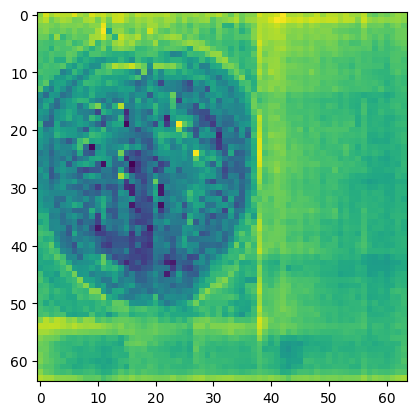

In [18]:
print(brain.shape, np.sum(image_embedding[0,:,:,:]))
plt.imshow(image_embedding[0,35,:,:])
plt.show()

In [52]:
input_point = np.array([[35,135]])
input_label = np.array([1])

# onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
# onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

# onnx_coord = transform.apply_coords(onnx_coord, [stacked_img.shape[0], stacked_img.shape[1]]).astype(np.float32)
print(nifti_slice.shape[0], nifti_slice.shape[1])
input_box = np.array([0, 0 , nifti_slice.shape[0], nifti_slice.shape[1]])
# input_box = np.array([100, 0, 200, 100])
input_point2 = np.array([[156, 0]])

onnx_box_coords = input_box.reshape(2, 2)
onnx_box_labels = np.array([2,3])

onnx_coord = np.concatenate([input_point, onnx_box_coords], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, onnx_box_labels], axis=0)[None, :].astype(np.float32)

# onnx_coord_tensor = torch.as_tensor(onnx_coord, dtype=torch.float, device="cpu")
# onnx_label_tensor = torch.as_tensor(onnx_label, dtype=torch.float, device="cpu")
# point_embedding = torch.cat([torch.sin(onnx_coord_tensor), torch.cos(onnx_coord_tensor)], dim=-1)
# point_labels = onnx_label_tensor.unsqueeze(-1).expand_as(point_embedding)
# print(point_embedding, point_labels)

onnx_coord = transform.apply_coords(onnx_coord, [nifti_slice.shape[1], nifti_slice.shape[0]]).astype(np.float32)
# print(onnx_coord)

onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

153 214


In [26]:
decoder_inputs = {
    "image_embeddings": image_embedding[60:61,:,:,:],
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array([stacked_img.shape[0], stacked_img.shape[1]], dtype=np.float32)
}

masks, _, low_res_logits = decoder_session.run(None, decoder_inputs)
masks = masks > 0.0

print(masks.shape)

plt.figure(figsize=(10,10))
plt.imshow(stacked_img)
show_mask(masks[0,0,:,:], plt.gca())
# show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

NameError: name 'image_embedding' is not defined

In [16]:
brain_nomask.shape[:2], nifti_slice.shape[-2:] 

((153, 214), (153, 214))

In [51]:
from skimage import transform as skimage_transform
import nibabel as nb
import SimpleITK as sitk

brain_nomask = nb.load('../images/sub-M2002_ses-a1440_T2w.nii').get_fdata()
# view_slices_3d(brain_nomask, slice_nbr=100, vmin=0, vmax=1000, title='Head')

nifti_slice = brain_nomask[:,:,96]
print(np.sum(nifti_slice), brain_nomask.shape)
print(nifti_slice.flatten()[19:25])
# nifti_slice = nifti_slice.astype(np.uint8)
image_size_encoder = 256
ori_w, ori_h = nifti_slice.shape[-2:]
padh = image_size_encoder - ori_h
padw = image_size_encoder - ori_w
print(np.amax(nifti_slice), ori_w, ori_h)
# flipped = np.flip(nifti_slice, 0)
# img_norm = (flipped - np.min(flipped)) / np.clip(flipped.max() - flipped.min(), a_min=1e-8, a_max=None) * 255
lower_bound, upper_bound = np.percentile(brain_nomask, 0.5), np.percentile(brain_nomask, 99.5)
image_data_pre = np.clip(brain_nomask, lower_bound, upper_bound)
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre[brain_nomask==0] = 0
image_data_pre = np.uint8(image_data_pre)
print(brain_nomask.shape, padh, padw, "pre mean=", np.mean(image_data_pre), "std=", np.std(image_data_pre), "min=", np.min(image_data_pre), "max=", np.max(image_data_pre))

# img_norm = (nifti_slice - np.min(nifti_slice)) / np.clip(nifti_slice.max() - nifti_slice.min(), a_min=1e-8, a_max=None) * 255
# resized_square = skimage_transform.resize(image_data_pre, (256, 256), order=3, preserve_range=True, mode='constant', anti_aliasing=True)

rotated = np.rot90(image_data_pre[:,:,96])
flipped = np.flip(rotated, 0)
# flipped_slice = flipped.astype(np.uint8)
img_slice_i_tensor = torch.as_tensor(flipped, device="cpu")
img_slice_i_tensor = F.pad(img_slice_i_tensor, (0, padw, 0, padh))
img_slice = img_slice_i_tensor.numpy()
print("pad mean=", np.mean(img_slice), "std=", np.std(img_slice), "min=", np.min(img_slice), "max=", np.max(img_slice))

stacked_img = np.stack((img_slice,)*3, axis=-1)
stacked_img = np.uint8(stacked_img)
print("nb mean=", np.mean(nifti_slice), "std=", np.std(nifti_slice), "min=", np.min(nifti_slice), "max=", np.max(nifti_slice))

print("stacked mean=", np.mean(stacked_img), "std=", np.std(stacked_img), "min=", np.min(stacked_img), "max=", np.max(stacked_img))
image_size = 1024
transform = ResizeLongestSide(image_size)

input_image = transform.apply_image(stacked_img)
print("input_image mean=", np.mean(input_image), "std=", np.std(input_image), "min=", np.min(input_image), "max=", np.max(input_image))

# input_image_torch = torch.as_tensor(input_image, device="cpu")
# input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
input_image_torch = torch.as_tensor(input_image.transpose(2, 0, 1), device="cpu")[None, :, :, :]
pixel_mean = torch.Tensor([123.675, 116.28, 103.53]).view(-1, 1, 1)
pixel_std = torch.Tensor([58.395, 57.12, 57.375]).view(-1, 1, 1)
x = (input_image_torch - pixel_mean) / pixel_std
h, w = x.shape[-2:]
padh_resizelongest = image_size - h
padw_resizelongest = image_size - w
x = F.pad(x, (0, padh_resizelongest, 0, padw_resizelongest))
x = x.numpy()
print("x mean=", np.mean(x), "std=", np.std(x), "min=", np.min(x), "max=", np.max(x))

x.shape

9654523.0 (153, 214, 187)
[11. 21.  8.  3.  8. 15.]
1228.0 153 214
(153, 214, 187) 42 103 pre mean= 51.38294238181054 std= 64.6803075646776 min= 0 max= 255
pad mean= 40.29933166503906 std= 62.145723077055955 min= 0 max= 255
nb mean= 294.86662390813024 std= 244.05802495539618 min= 0.0 max= 1228.0
stacked mean= 40.29933166503906 std= 62.145723077055955 min= 0 max= 255
input_image mean= 40.3557243347168 std= 61.29097132164338 min= 0 max= 255
x mean= -1.2857021 std= 1.0723925 min= -2.117904 max= 2.64


(1, 3, 1024, 1024)

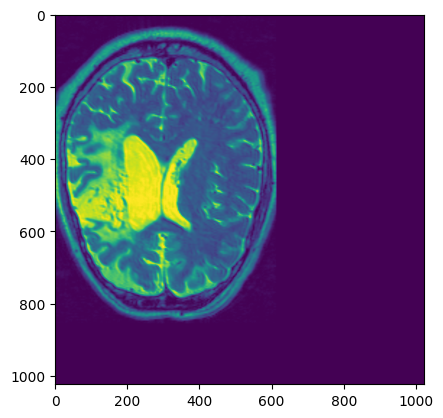

(1024, 1024, 3)


In [40]:
plt.imshow(input_image[:,:,1])
plt.show()
print(input_image.shape)

19.16658306121826


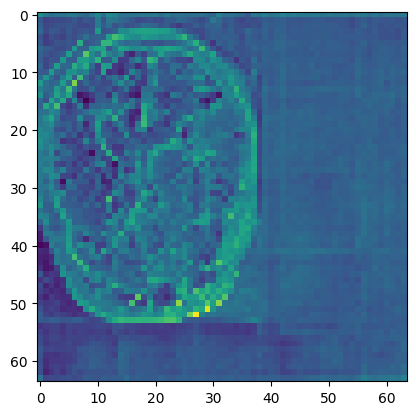

In [53]:
import time

start = time.time()
encoder_inputs = {
    "x": x,
}

output = encoder_session.run(None, encoder_inputs)
image_embedding_slice = output[0]
end = time.time()
print(end-start)

plt.imshow(image_embedding_slice[0,1,:,:])
plt.show()

In [23]:
print("embedding mean=", np.mean(image_embedding_slice), "std=", np.std(image_embedding_slice), "min=", np.min(image_embedding_slice), "max=", np.max(image_embedding_slice))

embedding mean= 0.011306694 std= 0.15807551 min= -1.0503012 max= 0.8183871


In [78]:

# img_norm = (flipped - np.min(flipped)) / np.clip(flipped.max() - flipped.min(), a_min=1e-8, a_max=None) * 255
lower_boun, upper_boun = np.percentile(nifti_slice, 0.5), np.percentile(nifti_slice, 99.5)
image_data_pr = np.clip(nifti_slice, lower_boun, upper_boun)
image_data_pr = (image_data_pr - np.min(image_data_pr))/(np.max(image_data_pr)-np.min(image_data_pr))*255.0
image_data_pr = np.uint8(image_data_pr)

rotate = np.rot90(image_data_pr)
flippe = np.flip(rotate, 0)
flipped_slic = flippe.astype(np.uint8)
stacked_im = np.stack((flipped_slic,)*3, axis=-1)


In [50]:
onnx_coord, onnx_label, np.array([nifti_slice.shape[1], nifti_slice.shape[0]])

(array([[[ 191.,  401.],
         [   0.,    0.],
         [ 732., 1023.]]], dtype=float32),
 array([[1., 2., 3.]], dtype=float32),
 array([214, 153]))

3427 mask mean= 0.1181459084152872 std= 0.32278081222404437 min= 0 max= 1
[214, 153] (1, 3, 214, 153) (1, 3) (1, 3, 214, 153) (1, 3, 256, 256)


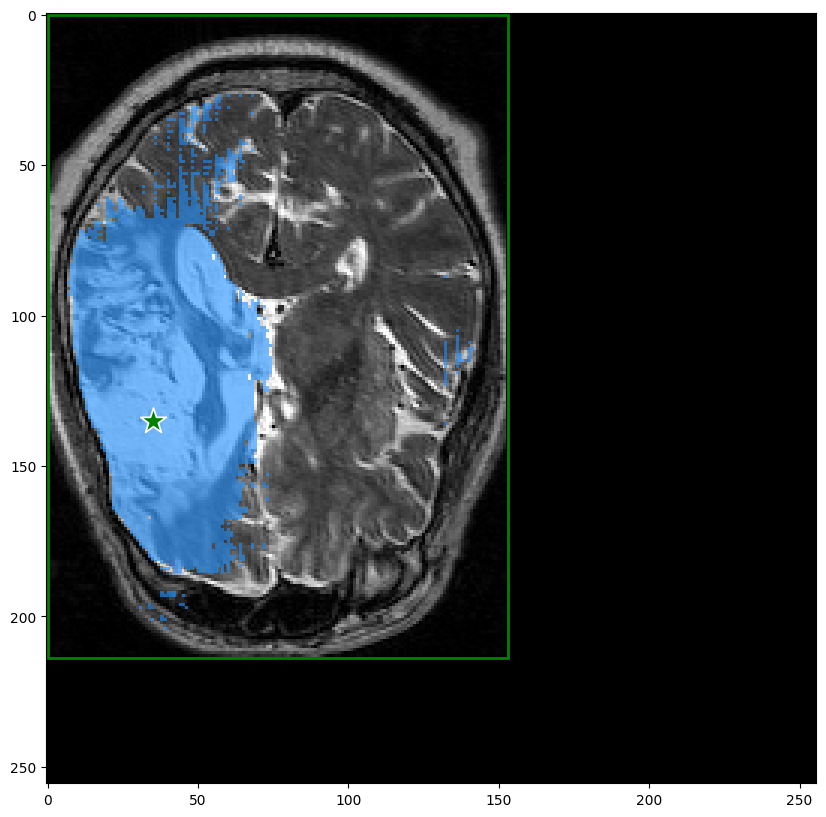

In [57]:
decoder_inputs = {
    "image_embeddings": image_embedding_slice,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array([nifti_slice.shape[1], nifti_slice.shape[0]], dtype=np.float32)
}

masks, scores, low_res_logits = decoder_session.run(None, decoder_inputs)
# medsam_seg_prob = torch.sigmoid(torch.as_tensor(low_res_logits, device="cpu"))
# mask = (medsam_seg_prob.cpu().numpy().squeeze() > 0.5).astype(np.uint8)
mask = (masks > 0.5).astype(np.uint8)
print(np.sum(mask[0, 2,:,:]), "mask mean=", np.mean(mask), "std=", np.std(mask), "min=", np.min(mask), "max=", np.max(mask))

print([nifti_slice.shape[1], nifti_slice.shape[0]], masks.shape, scores.shape, mask.shape, low_res_logits.shape)


plt.figure(figsize=(10,10))
plt.imshow(stacked_img)
show_mask(mask[0, 0,:,:], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [133]:
nifti_slice.shape[1], nifti_slice.shape[0]

(214, 153)

In [138]:
def resize_longest_image_size(
    input_image_size: torch.Tensor, longest_side: int
) -> torch.Tensor:
    input_image_size = input_image_size.to(torch.float32)
    scale = longest_side / torch.max(input_image_size)
    transformed_size = scale * input_image_size
    transformed_size = torch.floor(transformed_size + 0.5).to(torch.int64)
    return transformed_size
orig_im_size = np.array([nifti_slice.shape[1], nifti_slice.shape[0]], dtype=np.float32)
# orig_im_size = np.array([256,256], dtype=np.float32)

prepadded_size = resize_longest_image_size(torch.as_tensor(orig_im_size, device="cpu"), 256*4).to(torch.int64)

padh = (256 - orig_im_size[0])*4
padw = (256 - orig_im_size[1])*4

print(prepadded_size, masks.shape, orig_im_size, padh, padw)
# masks = masks[..., : prepadded_size[0], : prepadded_size[1]]

tensor([1024,  732]) (1, 4, 214, 153) [214. 153.] 168.0 412.0
